# Flower Recognition CNN



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

import os
print(os.listdir('/content/drive/MyDrive/flowers'))

['dandelion', 'rose', 'daisy', 'tulip', 'sunflower']


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

from PIL import Image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B2, MobileNetV2
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.utils import load_img
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import plot_model

In [6]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/content/drive/MyDrive/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/drive/MyDrive/flowers/sunflower'
FLOWER_TULIP_DIR='/content/drive/MyDrive/flowers/tulip'
FLOWER_DANDI_DIR='/content/drive/MyDrive/flowers/dandelion'
FLOWER_ROSE_DIR='/content/drive/MyDrive/flowers/rose'


In [7]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=flower_type
        path = os.path.join(DIR,img)
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [8]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:22<00:00, 33.23it/s] 

764


In [9]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:22<00:00, 32.65it/s]

1497


In [10]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:24<00:00, 39.55it/s] 

2481


In [11]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1062/1062 [00:27<00:00, 38.24it/s]

3543


In [12]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:18<00:00, 43.09it/s]

4327


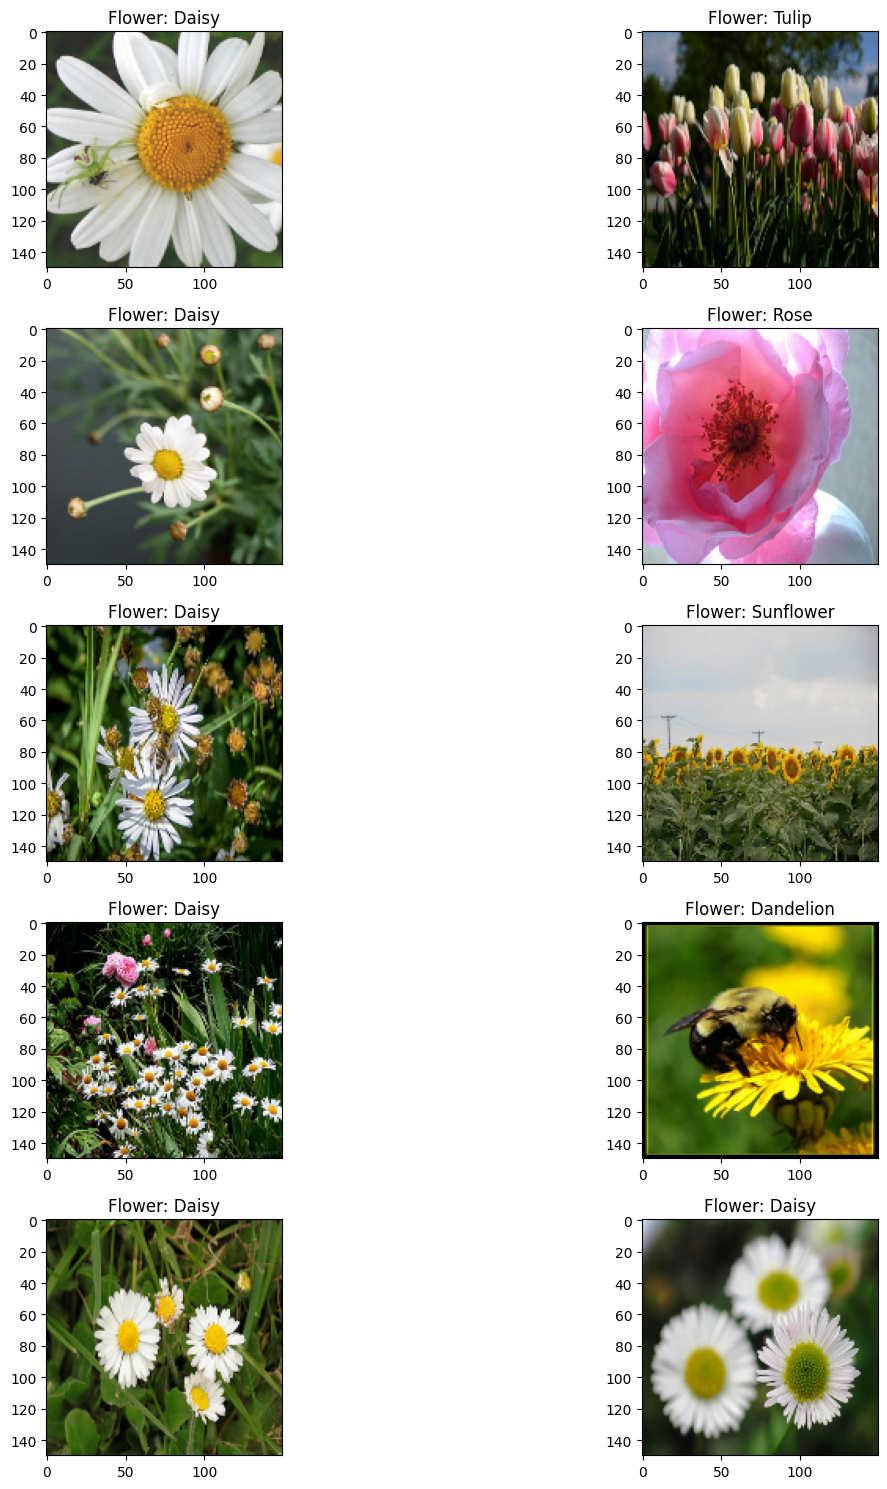

In [13]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()


In [14]:
# Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding
le=LabelEncoder()
Z=le.fit_transform(Z)
Y=to_categorical(Z,5)
X=np.array(X)
# X=X/255

In [15]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [16]:
#data augmentation
from tensorflow.keras.applications.resnet50 import preprocess_input

tr_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)


datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=False)

x_train2 = x_train
datagen.fit(x_train2)

tr_datagen.fit(x_train)

## Building the ConvNet Model

In [31]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [32]:
batch_size=128
epochs=25

In [40]:
model.compile(optimizer=Adam(lr=0.0009),loss='categorical_crossentropy',metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 18, 18, 96)       

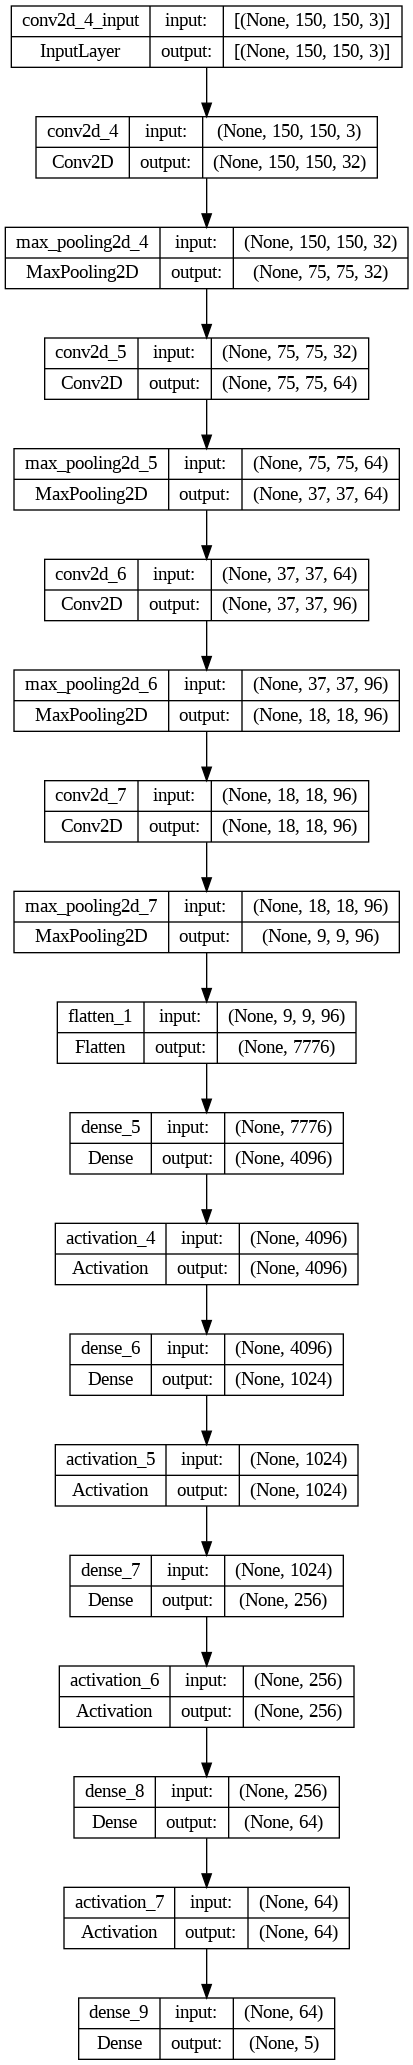

In [42]:
plot_model(model, show_shapes = True)

In [44]:
History = model.fit_generator(datagen.flow(x_train2,y_train, batch_size=batch_size),
                              epochs = 10, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

<ipython-input-44-2526d9656596>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  History = model.fit_generator(datagen.flow(x_train2,y_train, batch_size=batch_size),


Epoch 1/10
50/50 [==============================] - 36s 717ms/step - loss: 0.9302 - accuracy: 0.6338 - val_loss: 0.8880 - val_accuracy: 0.6664
Epoch 2/10
50/50 [==============================] - 36s 727ms/step - loss: 0.9397 - accuracy: 0.6347 - val_loss: 0.9135 - val_accuracy: 0.6451
Epoch 3/10
50/50 [==============================] - 36s 725ms/step - loss: 0.9249 - accuracy: 0.6353 - val_loss: 0.8447 - val_accuracy: 0.6802
Epoch 4/10
50/50 [==============================] - 35s 699ms/step - loss: 0.8738 - accuracy: 0.6562 - val_loss: 0.8091 - val_accuracy: 0.6858
Epoch 5/10
50/50 [==============================] - 36s 724ms/step - loss: 0.8469 - accuracy: 0.6694 - val_loss: 0.8724 - val_accuracy: 0.6733
Epoch 6/10
50/50 [==============================] - 38s 751ms/step - loss: 0.8538 - accuracy: 0.6672 - val_loss: 0.8063 - val_accuracy: 0.6765
Epoch 7/10
50/50 [==============================] - 36s 724ms/step - loss: 0.8232 - accuracy: 0.6852 - val_loss: 0.8059 - val_accuracy: 0.6978

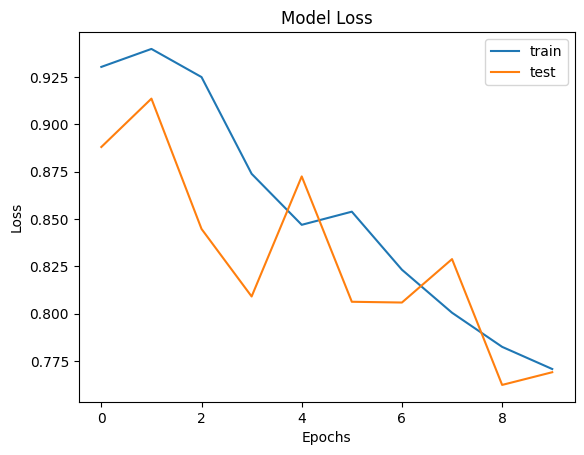

In [45]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

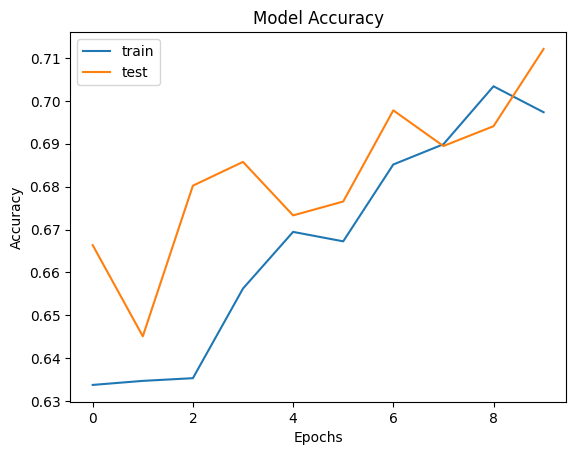

In [46]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


In [47]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

model_acc = accuracy_score(y_classes,pred_digits)
model_acc*100

68/68 [==============================] - 1s 8ms/step


71.21072088724584

In [48]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)


i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)


##ResNet50 Model

In [49]:
base_resnet50 = ResNet50(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_resnet50.layers:
    layer.trainable = False
# tf.keras.applications.resnet50.preprocess_input(
#     x_train, data_format=None
# );
# tf.keras.applications.resnet50.preprocess_input(
#     x_test, data_format=None
# );

94765736/94765736 [==============================] - 4s 0us/step


In [50]:
inputs = Input(shape=(150, 150, 3))
x = base_resnet50(inputs, training=False)
x = GlobalAveragePooling2D()(x)
# x = Dense(2048, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
# x = Dense(128, activation = 'relu')(x)
x = Dropout(0.45)(x)
x =Dense(5, activation='sigmoid')(x)

model_resnet50 = Model(inputs, x)
model_resnet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 5)                 2565      
                                                             

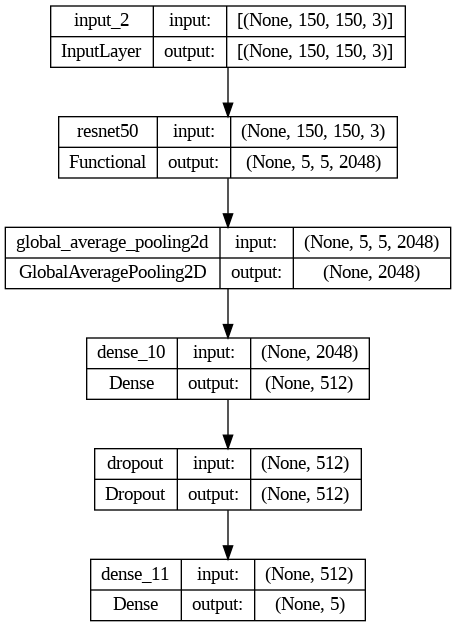

In [51]:
plot_model(model_resnet50, show_shapes = True)

In [52]:
model_resnet50.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_res50 = model_resnet50.fit(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = 10,
                              validation_data = (x_test,y_test),
                              verbose = 1,
                              steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/10
50/50 [==============================] - 58s 936ms/step - loss: 0.9506 - accuracy: 0.6892 - val_loss: 0.4658 - val_accuracy: 0.8332
Epoch 2/10
50/50 [==============================] - 43s 858ms/step - loss: 0.4715 - accuracy: 0.8268 - val_loss: 0.3940 - val_accuracy: 0.8558
Epoch 3/10
50/50 [==============================] - 43s 857ms/step - loss: 0.4137 - accuracy: 0.8485 - val_loss: 0.3842 - val_accuracy: 0.8637
Epoch 4/10
50/50 [==============================] - 43s 852ms/step - loss: 0.3788 - accuracy: 0.8554 - val_loss: 0.3359 - val_accuracy: 0.8762
Epoch 5/10
50/50 [==============================] - 41s 826ms/step - loss: 0.3478 - accuracy: 0.8728 - val_loss: 0.3184 - val_accuracy: 0.8826
Epoch 6/10
50/50 [==============================] - 41s 812ms/step - loss: 0.3074 - accuracy: 0.8865 - val_loss: 0.3067 - val_accuracy: 0.8896
Epoch 7/10
50/50 [==============================] - 40s 809ms/step - loss: 0.2900 - accuracy: 0.8915 - val_loss: 0.3156 - val_accuracy: 0.8896

In [53]:
acc_rn50 = history_res50.history['accuracy']
val_acc_rn50 = history_res50.history['val_accuracy']
loss_rn50 = history_res50.history['loss']
val_loss_rn50 = history_res50.history['val_loss']

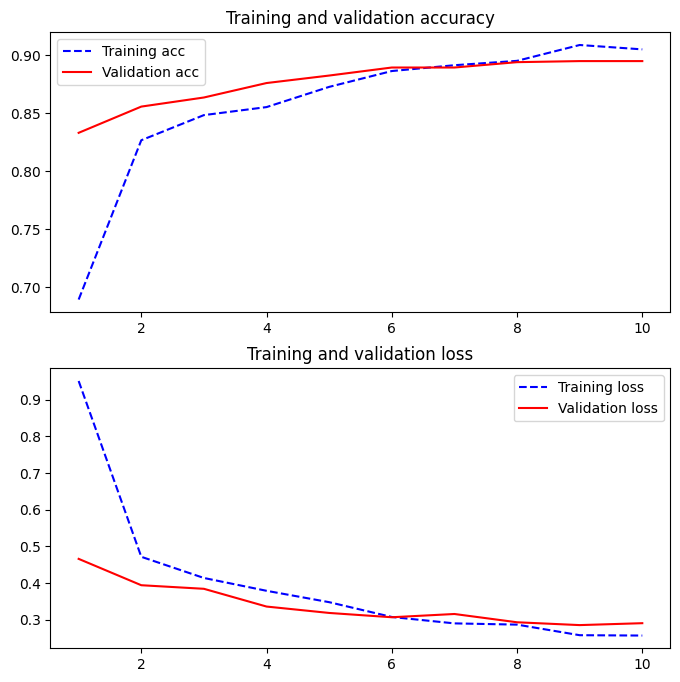

In [54]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_rn50) + 1)
ax[0].plot(epochs, acc_rn50, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_rn50, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_rn50, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_rn50, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()


In [55]:
pred=model_resnet50.predict(x_test)
pred_res50=np.argmax(pred,axis=1)

y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

rn_acc = accuracy_score(y_classes,pred_res50)
print(rn_acc)

68/68 [==============================] - 4s 48ms/step
0.8951016635859519


##Efficient Net

In [17]:
base_effnet = EfficientNetV2B2(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_effnet.layers:
    layer.trainable = False

35839040/35839040 [==============================] - 0s 0us/step


In [18]:
inputs = Input(shape=(150, 150, 3))
x = base_effnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(5, activation='softmax')(x)

model_effnet = Model(inputs, x)
model_effnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 5, 5, 1408)        8769374   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1442816   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 128)               65664 

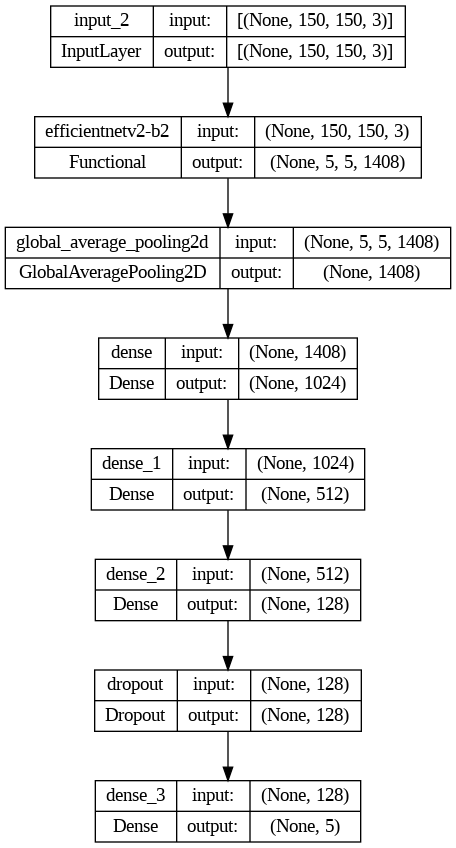

In [19]:
plot_model(model_effnet, show_shapes = True)

In [20]:
batch_size=128
epochs=25

In [21]:
model_effnet.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_ef = model_effnet.fit(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = 10,
                              validation_data = (x_test,y_test),
                              verbose = 1,
                              steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/10
25/25 [==============================] - 44s 1s/step - loss: 0.6650 - accuracy: 0.7539 - val_loss: 0.3523 - val_accuracy: 0.8752
Epoch 2/10
25/25 [==============================] - 18s 728ms/step - loss: 0.3425 - accuracy: 0.8791 - val_loss: 0.3311 - val_accuracy: 0.8882
Epoch 3/10
25/25 [==============================] - 20s 815ms/step - loss: 0.2795 - accuracy: 0.9078 - val_loss: 0.3082 - val_accuracy: 0.8826
Epoch 4/10
25/25 [==============================] - 20s 798ms/step - loss: 0.2286 - accuracy: 0.9150 - val_loss: 0.3289 - val_accuracy: 0.8909
Epoch 5/10
25/25 [==============================] - 19s 777ms/step - loss: 0.1815 - accuracy: 0.9355 - val_loss: 0.3187 - val_accuracy: 0.9030
Epoch 6/10
25/25 [==============================] - 18s 733ms/step - loss: 0.1554 - accuracy: 0.9461 - val_loss: 0.3460 - val_accuracy: 0.8909
Epoch 7/10
25/25 [==============================] - 20s 784ms/step - loss: 0.1581 - accuracy: 0.9471 - val_loss: 0.3145 - val_accuracy: 0.9057
Ep

In [22]:
acc_ef = history_ef.history['accuracy']
val_acc_ef = history_ef.history['val_accuracy']
loss_ef = history_ef.history['loss']
val_loss_ef = history_ef.history['val_loss']

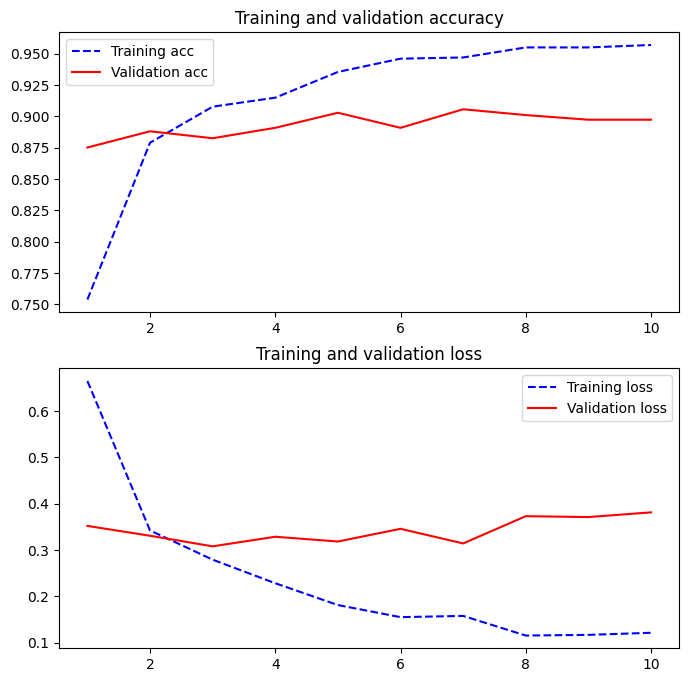

In [23]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_ef) + 1)
ax[0].plot(epochs, acc_ef, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_ef, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_ef, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_ef, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [24]:
pred=model_effnet.predict(x_test)
pred_ef=np.argmax(pred,axis=1)

y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

model_acc = accuracy_score(y_classes,pred_ef)
model_acc


34/34 [==============================] - 4s 35ms/step


0.8974121996303143

##VGG16

In [25]:
from tensorflow.keras.applications import VGG16
base_vgg = VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [26]:
inputs = Input(shape=(150, 150, 3))
x = base_vgg(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(5, activation='softmax')(x)

model_vgg = Model(inputs, x)
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                           

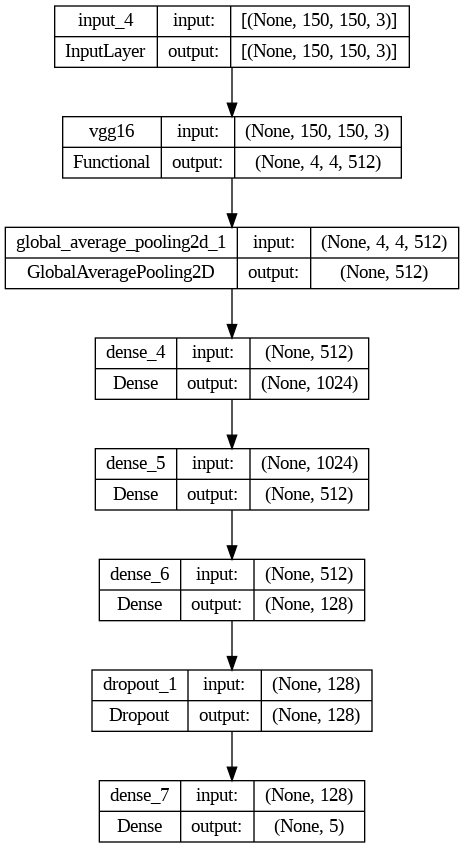

In [27]:
plot_model(model_vgg, show_shapes = True)

In [28]:
batch_size=128
epochs=25

In [29]:
model_vgg.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_vgg = model_vgg.fit(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = 10,
                              validation_data = (x_test,y_test),
                              verbose = 1,
                              steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/10
25/25 [==============================] - 43s 1s/step - loss: 1.5081 - accuracy: 0.5967 - val_loss: 0.7013 - val_accuracy: 0.7394
Epoch 2/10
25/25 [==============================] - 22s 885ms/step - loss: 0.6542 - accuracy: 0.7536 - val_loss: 0.6300 - val_accuracy: 0.7773
Epoch 3/10
25/25 [==============================] - 22s 863ms/step - loss: 0.5416 - accuracy: 0.7972 - val_loss: 0.5875 - val_accuracy: 0.7957
Epoch 4/10
25/25 [==============================] - 22s 863ms/step - loss: 0.5117 - accuracy: 0.8049 - val_loss: 0.5735 - val_accuracy: 0.7957
Epoch 5/10
25/25 [==============================] - 21s 841ms/step - loss: 0.4845 - accuracy: 0.8252 - val_loss: 0.6049 - val_accuracy: 0.7911
Epoch 6/10
25/25 [==============================] - 22s 871ms/step - loss: 0.4456 - accuracy: 0.8341 - val_loss: 0.5384 - val_accuracy: 0.8152
Epoch 7/10
25/25 [==============================] - 21s 827ms/step - loss: 0.4120 - accuracy: 0.8473 - val_loss: 0.5393 - val_accuracy: 0.8115
Ep

In [30]:
acc_vgg = history_vgg.history['accuracy']
val_acc_vgg = history_vgg.history['val_accuracy']
loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']

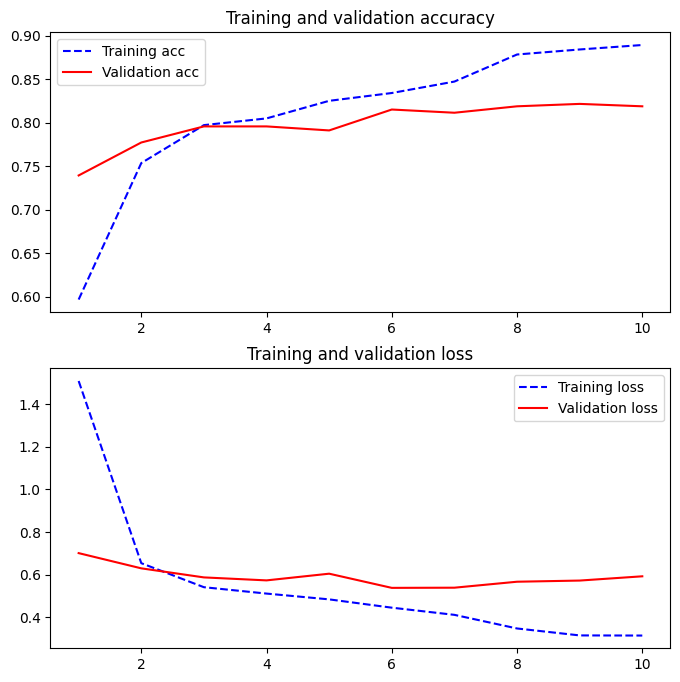

In [31]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_vgg) + 1)
ax[0].plot(epochs, acc_vgg, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_vgg, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_vgg, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_vgg, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [32]:
pred=model_vgg.predict(x_test)
pred_vgg=np.argmax(pred,axis=1)

y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

model_acc = accuracy_score(y_classes,pred_vgg)
model_acc

34/34 [==============================] - 2s 66ms/step


0.8188539741219963

In [42]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_vgg[i]):
        prop_class.append(i)


i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_vgg[i]):
        mis_class.append(i)


#### CORRECTLY CLASSIFIED FLOWER IMAGES

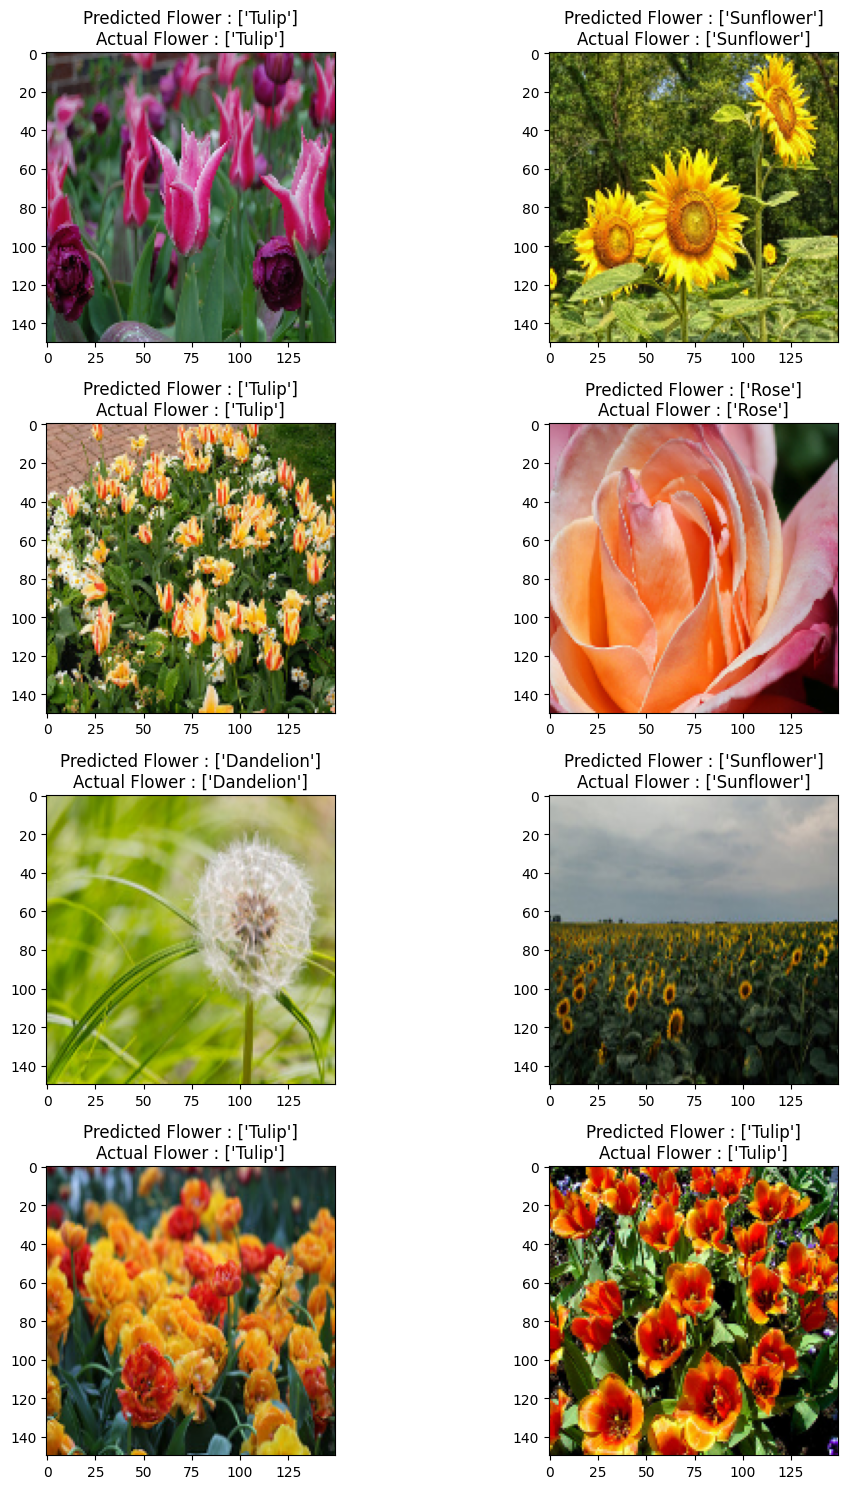

In [44]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_vgg[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(([y_classes[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

#### MISCLASSIFIED IMAGES OF FLOWERS

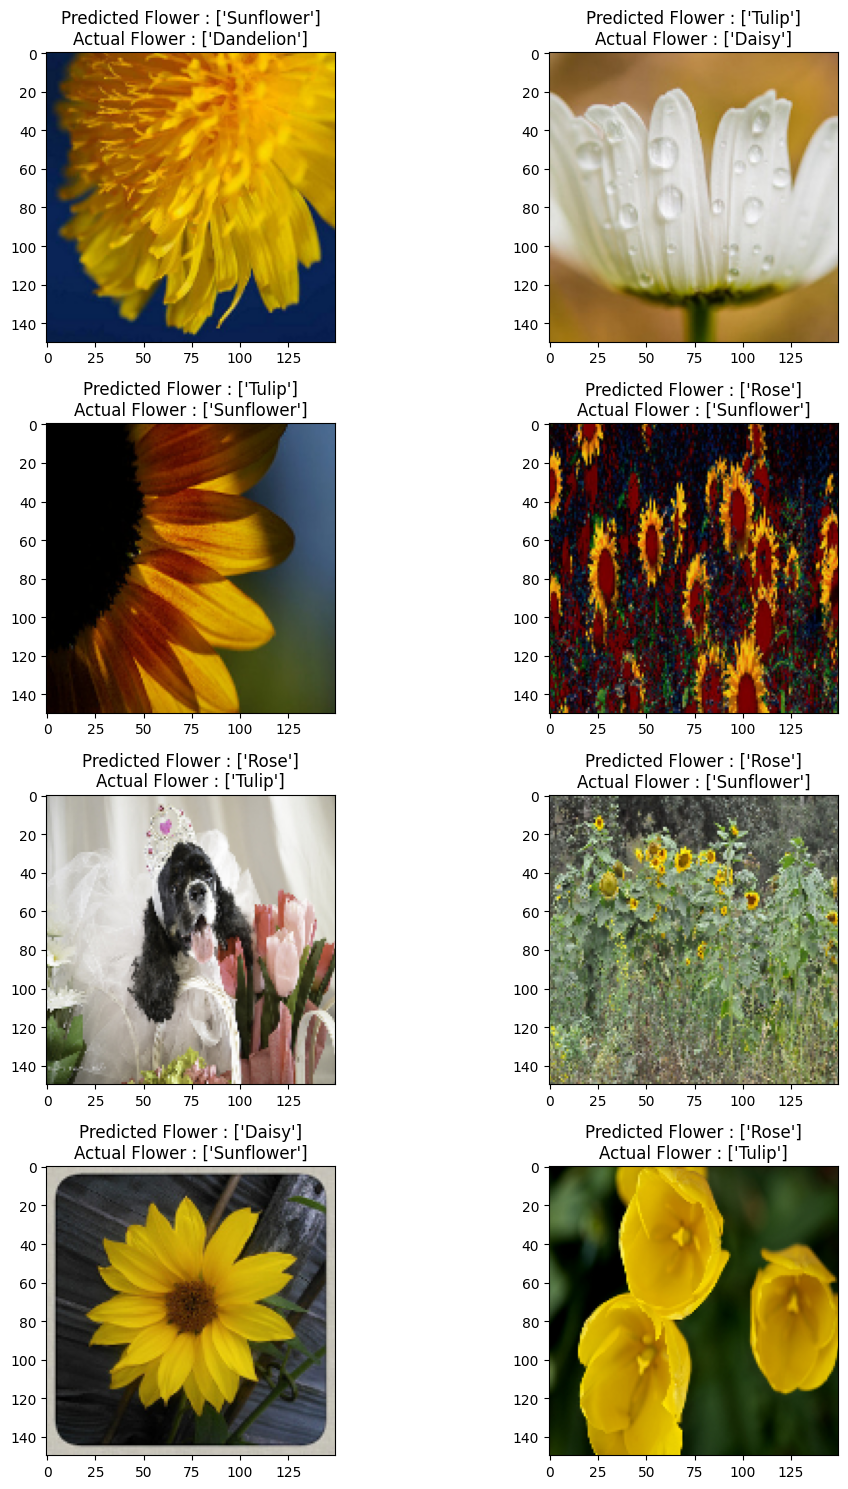

In [45]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_vgg[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(([y_classes[mis_class[count]]]))))
        plt.tight_layout()
        count+=1